In [54]:
import pandas as pd
df = pd.read_csv('csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,151
1,2015-01-02,160
2,2015-01-03,145
3,2015-01-04,153
4,2015-01-05,171


In [55]:
df['Data'] = pd.to_datetime(df['Data'])
df.head()

,Data,Totale
0,2015-01-01,151
1,2015-01-02,160
2,2015-01-03,145
3,2015-01-04,153
4,2015-01-05,171


In [38]:
df.set_index('Data', inplace=True)
df.head()

,Totale
Data,
2015-01-01,151
2015-01-02,160
2015-01-03,145
2015-01-04,153
2015-01-05,171


In [39]:
#creo la time series
ts = df['Totale']
ts.head()

Data
2015-01-01    151
2015-01-02    160
2015-01-03    145
2015-01-04    153
2015-01-05    171
Name: Totale, dtype: int64

In [40]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

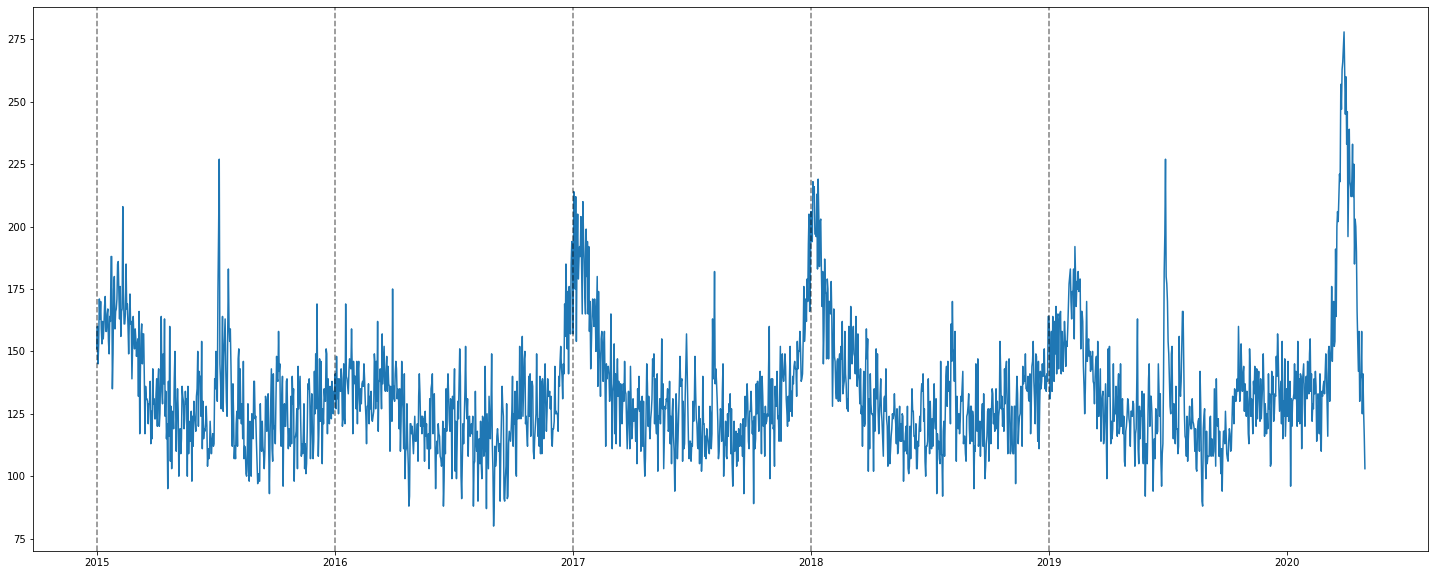

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

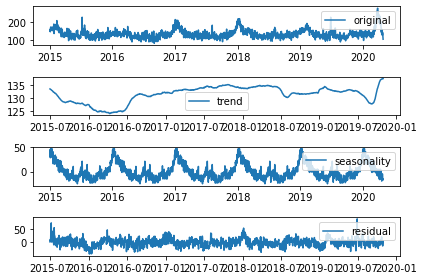

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365)

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [43]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

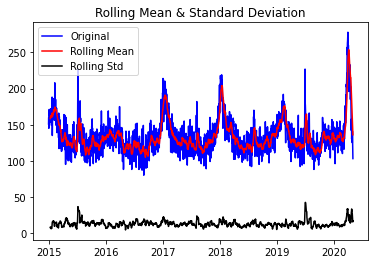

Results of Dickey-Fuller Test:
Test Statistic                   -5.009488
p-value                           0.000021
#Lags Used                        8.000000
Number of Observations Used    1936.000000
Critical Value (1%)              -3.433732
Critical Value (5%)              -2.863034
Critical Value (10%)             -2.567565
dtype: float64
X is stationary


In [44]:
test_stationarity(lim_ts)

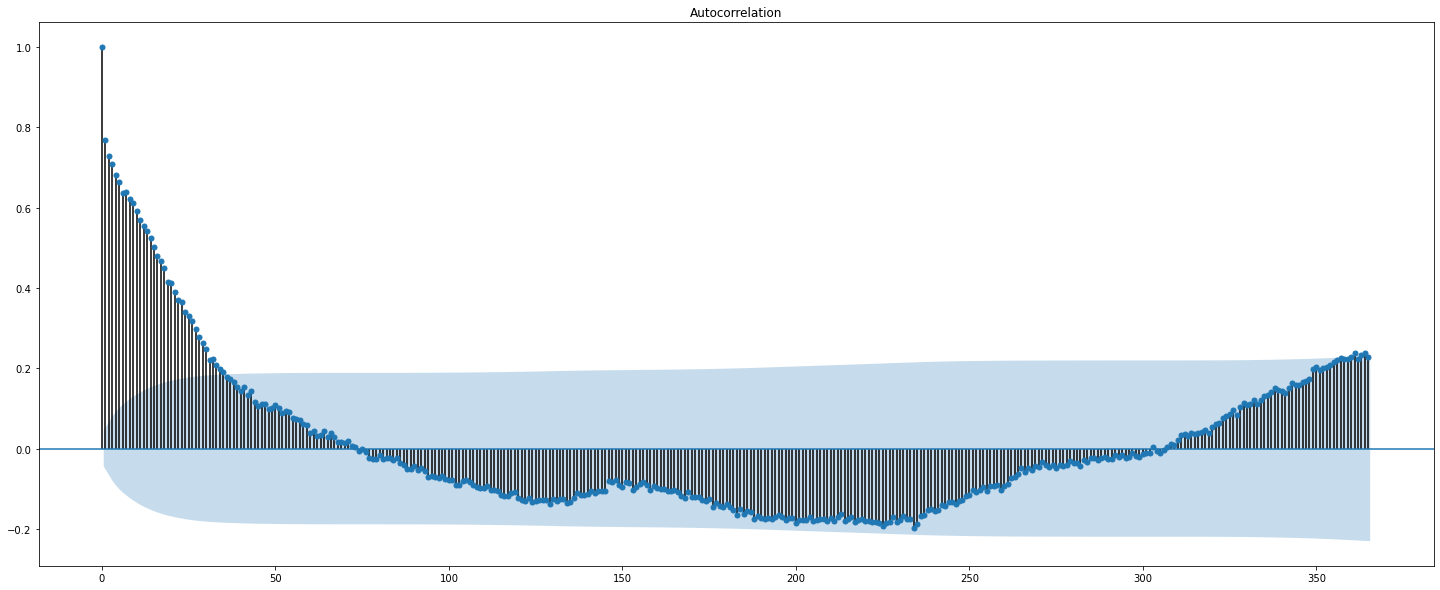

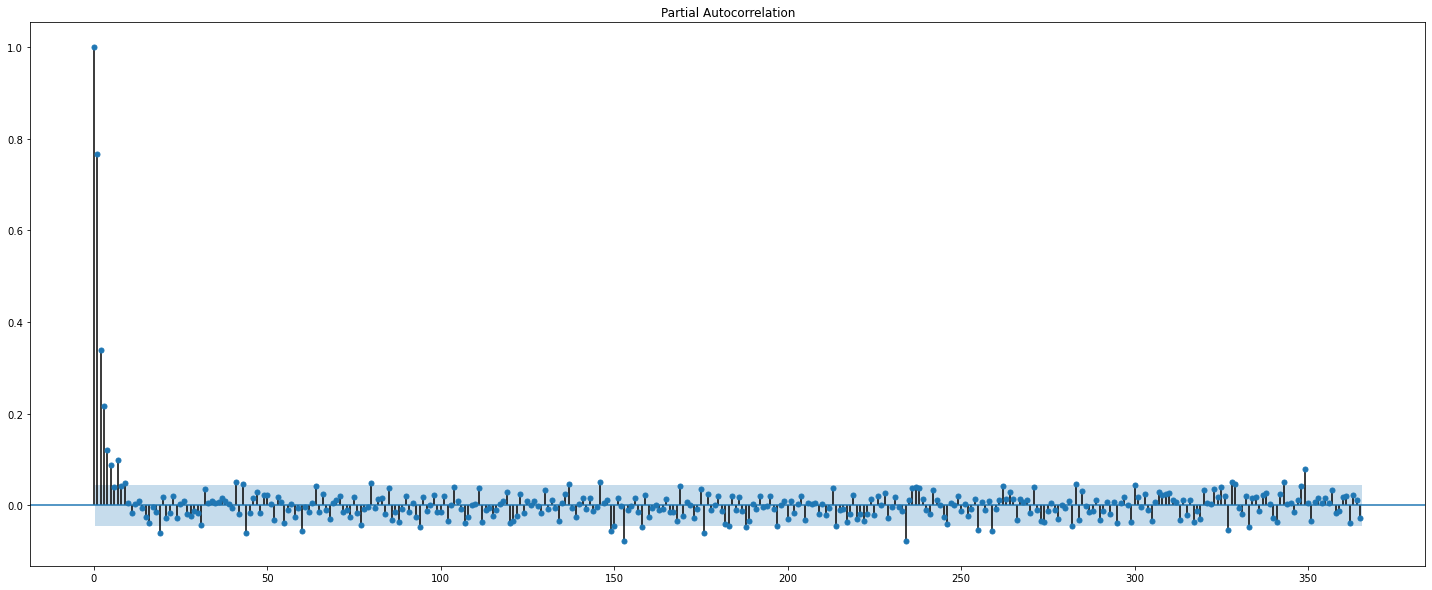

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_acf,ax_acf = plt.subplots(figsize=(25, 10))
fig_pacf,ax_pacf = plt.subplots(figsize=(25, 10))
plot_acf(ts, lags =365, ax=ax_acf)
plot_pacf(ts, lags =365, ax=ax_pacf)
plt.show()

In [46]:
from datetime import datetime
train_end = datetime(2018,7,7)
test_end = datetime (2020,4,30)

train = ts[:train_end]
test = ts[train_end + timedelta(days=1): test_end]


In [47]:
train

Data
2015-01-01    151
2015-01-02    160
2015-01-03    145
2015-01-04    153
2015-01-05    171
             ... 
2018-07-03    130
2018-07-04    119
2018-07-05    111
2018-07-06    123
2018-07-07    112
Name: Totale, Length: 1283, dtype: int64

In [48]:
train.to_csv('train.csv')

In [49]:
test

Data
2018-07-08    126
2018-07-09    137
2018-07-10    123
2018-07-11    119
2018-07-12    131
             ... 
2020-04-26    125
2020-04-27    141
2020-04-28    126
2020-04-29    116
2020-04-30    103
Name: Totale, Length: 662, dtype: int64

In [52]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 1
q = 1
d = 0
model = SARIMAX(train, order=(p,d,q))
model_fit = model.fit(disp=1,solver='powell')
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                 Totale   No. Observations:                 1283
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -5217.513
Date:                Mon, 13 Jul 2020   AIC                          10441.027
Time:                        17:34:48   BIC                          10456.497
Sample:                             0   HQIC                         10446.835
                               - 1283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001   1345.650      0.000       0.998       1.001
ma.L1         -0.7409      0.015    -49.921      0.000      -0.770      -0.712
sigma2       198.5758      6.922     28.689      0.0

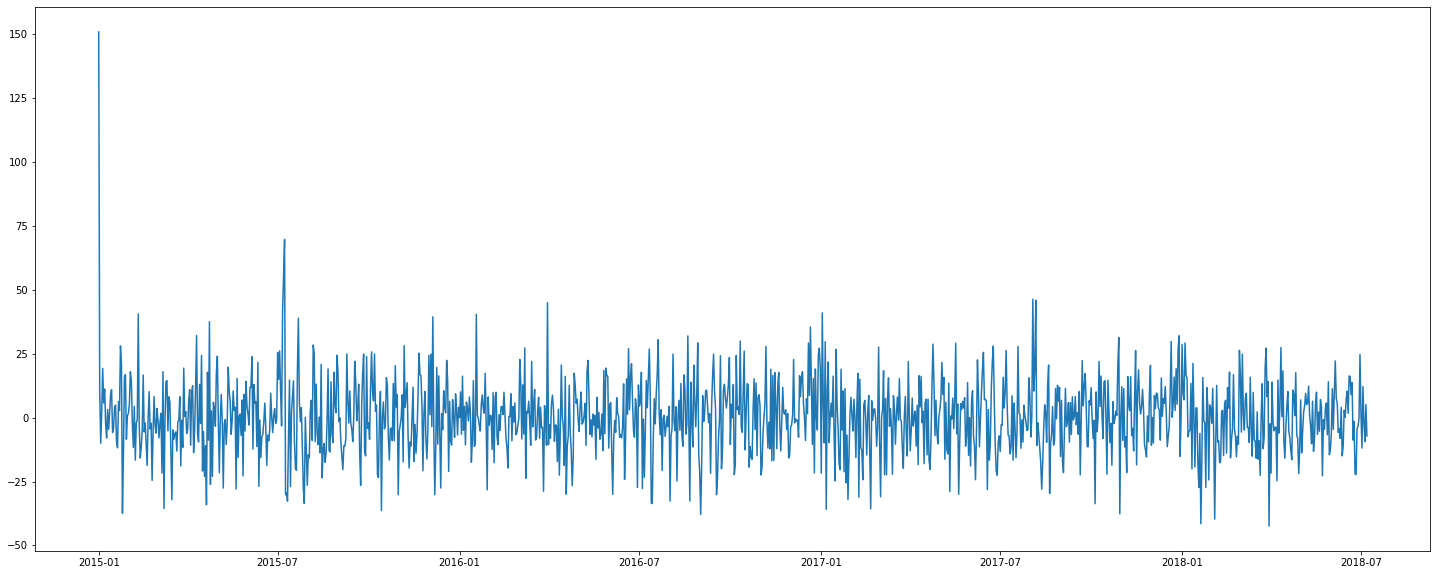

In [26]:
residuals = model_fit.resid
plt.figure(figsize=(25,10))
plt.plot(residuals)

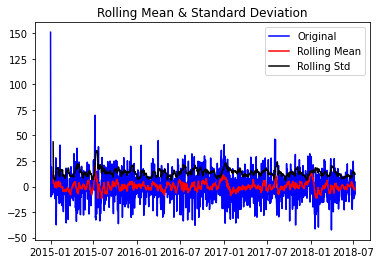

Results of Dickey-Fuller Test:
Test Statistic                  -35.046244
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1282.000000
Critical Value (1%)              -3.435461
Critical Value (5%)              -2.863797
Critical Value (10%)             -2.567972
dtype: float64
X is stationary


In [27]:
test_stationarity(residuals)

In [28]:
residuals.describe()

count    1283.000000
mean        0.194740
std        14.709346
min       -42.453573
25%        -8.789319
50%         0.158241
75%         8.701473
max       151.000000
dtype: float64

In [29]:
predictions = model_fit.predict(start=train[0], end=len(train))

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [30]:
predictions

151     120.577549
152     120.902606
153     120.108506
154     123.142432
155     126.166499
           ...    
1279    120.913750
1280    120.375497
1281    117.906824
1282    119.182576
1283    117.281713
Length: 1133, dtype: float64

In [86]:
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions, test)/(np.max(test)-np.min(test))
print("RMSE =" , nrmse)

NameError: name 'predictions' is not defined